Problem: ORCA grid is not in spherical coordinates - it is a general curvilinear grid. So, X velocity does not mean zonal and Y velocity does not mean meridional. So, interpolating U/V before rotating is a problem. What is the Ocean Navigator doing???

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import scipy.interpolate as interp

%matplotlib inline

# Grid angle

Find the angle between X grid lines and East

In [2]:
def grid_angle(lons, lats):
    """ Assumes lons, lats are shape (y,x) in degrees
        Find the angle between longitude grid lines and East.
            θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    """
    dlons = np.radians(lons[:,1:] - lons[:, 0:-1])
    lat1 = np.radians(lats[:, 0:-1])
    lat2 = np.radians(lats[:, 1:])
    
    theta=np.empty_like(lons)
    x = np.sin(dlons)*np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1)* np.cos(lat2) * np.cos(dlons))
    
    # Extend theta by copying last column (How do we treat the boundary point?)
    theta[:, 0:-1] = np.arctan2(x,y)
    theta[:,-1] = theta[:,-2]
    # Theta is the angle with North so subtact from pi/2 for angle with East
    return np.rad2deg(np.pi/2 - theta)

Check with Susan's grid. Answer should be about 29 degrees

In [3]:
fname = '/data/hdd/salishsea/grid/bathymetry_201702.nc'
f = nc.Dataset(fname)

lon = f.variables['nav_lon']
lat = f.variables['nav_lat']

theta = grid_angle(lon, lat)

In [4]:
print(theta, theta.min(), theta.max())

(array([[ 27.35059139,  27.35141042,  27.35222953, ...,  27.34161722,
         27.34244556,  27.34244556],
       [ 29.69382212,  28.69889927,  28.21956712, ...,  27.34342398,
         27.34425247,  27.34425247],
       [ 30.47954156,  29.48475463,  28.91223157, ...,  27.3933096 ,
         27.34605973,  27.34605973],
       ..., 
       [ 29.71373019,  29.57758454,  29.44105299, ...,  28.78902816,
         28.71444947,  28.71444947],
       [ 29.67441756,  29.57186637,  29.39009521, ...,  28.69758813,
         28.77799967,  28.77799967],
       [ 29.64793259,  29.46790378,  29.33950988, ...,  28.73931774,
         28.72585503,  28.72585503]]), -11.285471695631522, 97.708242588719415)


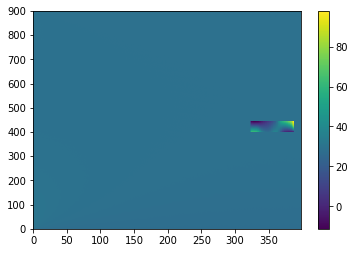

In [5]:
plt.pcolormesh(theta)
plt.colorbar()

Approximately 29 degrees everywhere except in the Fraser river which was mapped to better for the shape of the river channel.

## Test on GIOPS

In [6]:
fname = '/data/hdd/giops/daily/201801/giops_2018012600_024.nc'
f = nc.Dataset(fname)
jss,jee = 0,1021
iss,iee = 0,1442

temp = f.variables['votemper'][0,0,jss:jee,iss:iee]
lon = f.variables['nav_lon'][jss:jee,iss:iee]
lon=lon.data
lat = f.variables['nav_lat'][jss:jee,iss:iee]

In [7]:
theta = grid_angle(lon, lat)
print(theta, theta.min(), theta.max())

(array([[ -1.21871062e-01,  -1.21871062e-01,  -1.21871062e-01, ...,
         -1.21871062e-01,  -1.21871062e-01,  -1.21871062e-01],
       [ -1.22219399e-01,  -1.22219399e-01,  -1.22219399e-01, ...,
         -1.22219399e-01,  -1.22219399e-01,  -1.22219399e-01],
       [ -1.21700302e-01,  -1.21700302e-01,  -1.21700302e-01, ...,
         -1.21700302e-01,  -1.21700302e-01,  -1.21700302e-01],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   8.11600494e+01, ...,
         -8.11558075e+01,   0.00000000e+00,   0.00000000e+00],
       [  9.00000000e+01,   9.00000000e+01,   9.00000000e+01, ...,
         -9.00000000e+01,   9.00000000e+01,   9.00000000e+01],
       [  2.10062927e+02,   1.49936172e+02,   1.08225189e+02, ...,
          2.51762405e+02,   2.10062927e+02,   2.10062927e+02]], dtype=float32), -90.0, 269.09592)


/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b

Text(0.5,1,u'Angle of rotation from X-grid lines to East in GIOPS')

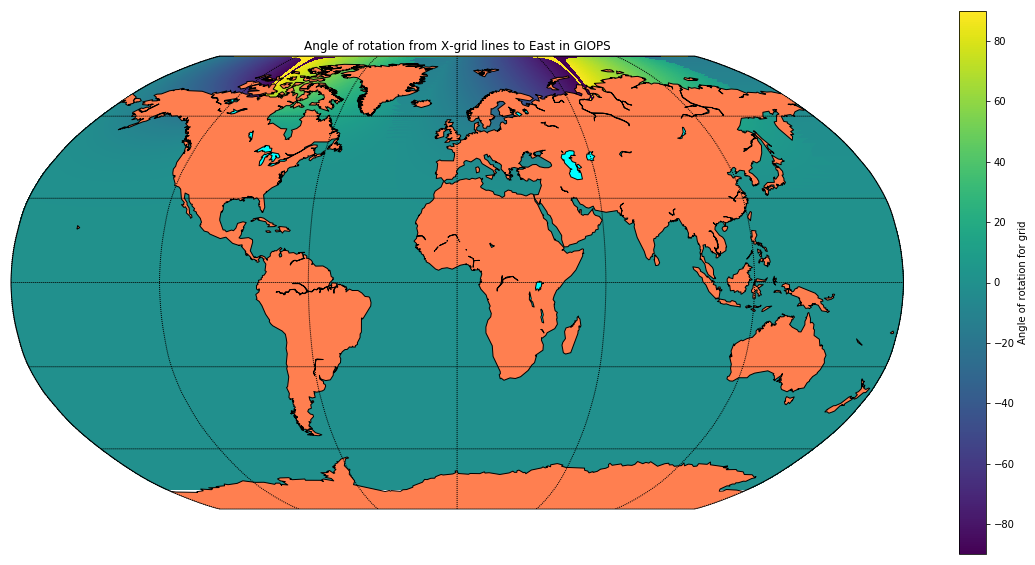

In [8]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
bmap = Basemap(projection='robin',lon_0=0,resolution='c')
bmap.drawcoastlines()
bmap.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
bmap.drawparallels(np.arange(-90.,120.,30.))
bmap.drawmeridians(np.arange(0.,360.,60.))
x,y=bmap(lon, lat)
mesh=bmap.pcolormesh(x,y,theta)
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('Angle of rotation for grid')
ax.set_title('Angle of rotation from X-grid lines to East in GIOPS')

Text(0.5,1,u'Angle of rotation from X-grid lines to East in GIOPS')

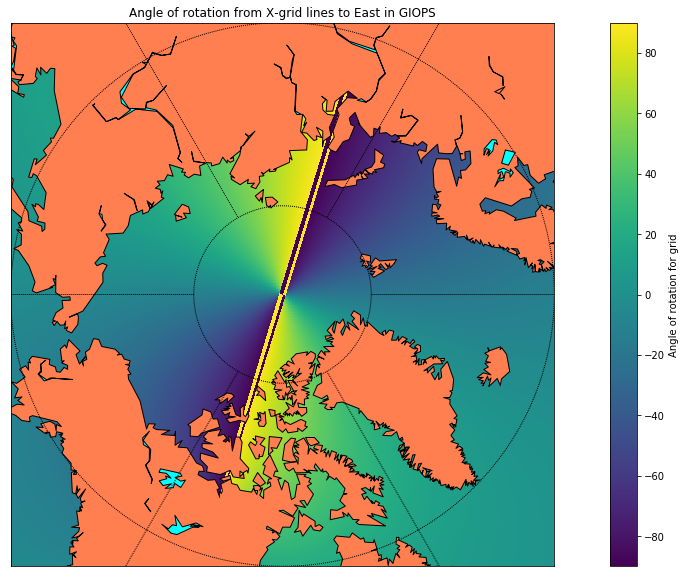

In [9]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
bmap = Basemap(projection='npstere',boundinglat=60,lon_0=270,resolution='c')
bmap.drawcoastlines()
bmap.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
bmap.drawparallels(np.arange(-90.,120.,30.))
bmap.drawmeridians(np.arange(0.,360.,60.))
x,y=bmap(lon, lat)
mesh=bmap.pcolormesh(x,y,theta)
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('Angle of rotation for grid')
ax.set_title('Angle of rotation from X-grid lines to East in GIOPS')

## Rotating velocities

In [10]:
def rotate_velocity(xv, yv, theta):
    """Rotate velocity vector (xv, yv) to new coordinate system.
    theta is the counterclockise angle measured from the x-axis of new coordinate system 
    and the x-axis of the (xv, yv) coordinate system
    If theta represents the angle between x grid lines and East than the result 
    is zonal (U) and meridional (V) velocities
    returns U,V - velocity along x and y axis in new coordinate system"""
    theta_rad = np.radians(theta)
    U = xv*np.cos(theta_rad) - yv*np.sin(theta_rad)
    V = xv*np.sin(theta_rad) + yv*np.cos(theta_rad)
    return U, V

In [11]:
X_velocity = f.variables['vozocrtx'][0,0,jss:jee,iss:iee]
Y_velocity = f.variables['vomecrty'][0,0,jss:jee,iss:iee]

U, V = rotate_velocity(X_velocity, Y_velocity, theta)

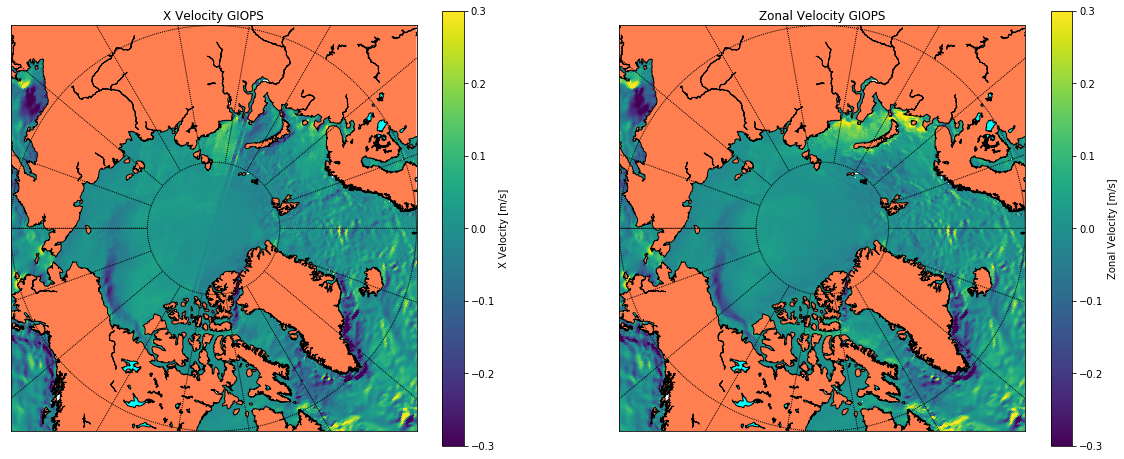

In [12]:
fig,axs=plt.subplots(1,2,figsize=(20,8))
for ax, vel, label in zip(axs, [X_velocity, U], ['X Velocity', 'Zonal Velocity']):
    bmap = Basemap(projection='npstere',boundinglat=60,lon_0=270,resolution='l', ax=ax)
    bmap.drawcoastlines()
    bmap.fillcontinents(color='coral',lake_color='aqua')
    bmap.drawparallels(np.arange(-80.,81.,20.))
    bmap.drawmeridians(np.arange(-180.,181.,20.))
    x,y=bmap(lon, lat)
    mesh=bmap.pcolormesh(x,y,vel,vmin=-.3, vmax=.3)
    cbar=plt.colorbar(mesh, ax=ax)
    cbar.set_label('{} [m/s]'.format(label))
    ax.set_title('{} GIOPS'.format(label))

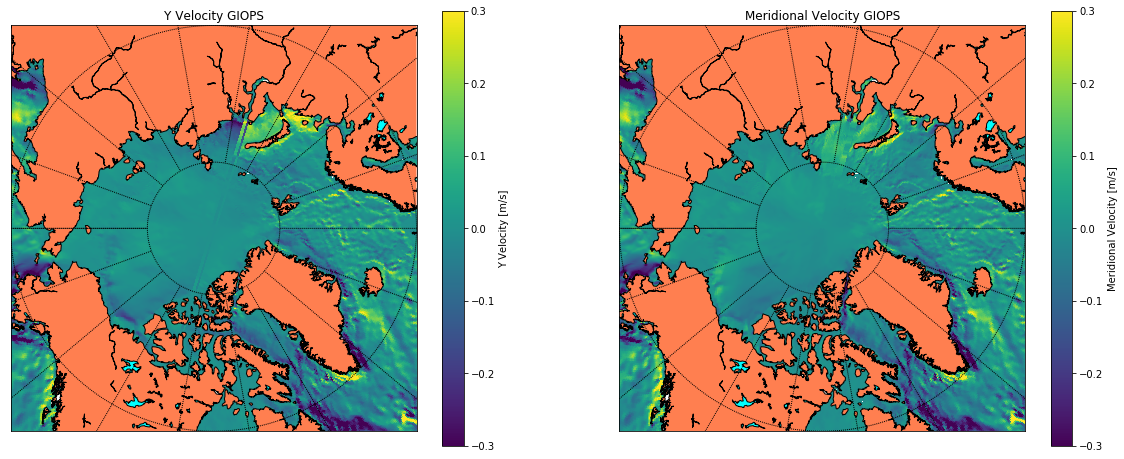

In [13]:
fig,axs=plt.subplots(1,2,figsize=(20,8))
for ax, vel, label in zip(axs, [Y_velocity, V], ['Y Velocity', 'Meridional Velocity']):
    bmap = Basemap(projection='npstere',boundinglat=60,lon_0=270,resolution='l', ax=ax)
    bmap.drawcoastlines()
    bmap.fillcontinents(color='coral',lake_color='aqua')
    bmap.drawparallels(np.arange(-80.,81.,20.))
    bmap.drawmeridians(np.arange(-180.,181.,20.))
    x,y=bmap(lon, lat)
    mesh=bmap.pcolormesh(x,y,vel,vmin=-.3, vmax=.3)
    cbar=plt.colorbar(mesh, ax=ax)
    cbar.set_label('{} [m/s]'.format(label))
    ax.set_title('{} GIOPS'.format(label))

## Quivers

/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


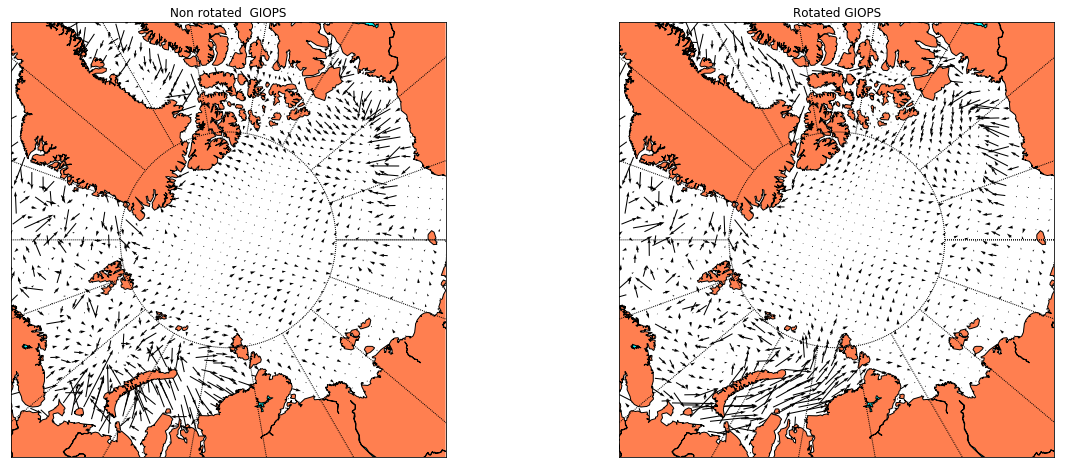

In [14]:
st=8
fig,axs=plt.subplots(1,2,figsize=(20,8))
for ax, xvel, yvel, label in zip(axs, [X_velocity, U],[Y_velocity, V], ['Non rotated ', 'Rotated']):
    bmap = Basemap(projection='npstere',boundinglat=70,lon_0=90,resolution='l', ax=ax)
    bmap.drawcoastlines()
    bmap.fillcontinents(color='coral',lake_color='aqua')
    bmap.drawparallels(np.arange(-80.,81.,20.))
    bmap.drawmeridians(np.arange(-180.,181.,20.))
    #mag = np.sqrt(xvel**2+yvel**2)
    #mesh=bmap.pcolormesh(lon,lat,mag,latlon=True,vmin=0,vmax=.5)
    bmap.quiver(lon[::st,::st],lat[::st,::st],xvel[::st,::st],yvel[::st,::st],latlon=True,scale=3)
    #cbar=plt.colorbar(mesh, ax=ax)
    #cbar.set_label('{} [m/s]'.format(label))
    ax.set_title('{} GIOPS'.format(label))